# StarCraft Pro Scout Modeling - Parametric Modeling - Logistic Regression


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.dummy import DummyClassifier

import scikitplot as skplt

import pickle

# Update sys.path
import sys
sys.path.append("../modules")

from scproModules import print_confusion_matrix, score_df, plot_grid_scores


In [2]:
# Pickle opening code to import cleaned data
with open('./pickles/sc_dataclean.pickle','rb') as read_file:
    scns = pickle.load(read_file)

## Parametric Model Features

- APM
- NumberOfPACs
- ActionLatency
- TotalMapExplored
- UniqueUnitsMade

## Binary Classifying
- Split into Contender and Non-Contender classes

In [3]:
# Rename labels and resplit. The target label must be 0
scns.LeagueIndex.replace({8:1, 7:1, 6:1, 5:0, 4:0, 3:0, 2:0, 1:0}, inplace=True)
scns.LeagueIndex.value_counts().sort_index()

0    2667
1     700
Name: LeagueIndex, dtype: int64

## Train-Test-Split

In [4]:
# Establish feature set
p_features = ['APM',
              'NumberOfPACs',
              'ActionLatency',
              'TotalMapExplored',
              'UniqueUnitsMade']

In [5]:
# Set features X and target y
X = scns.loc[:, p_features]
y = scns['LeagueIndex']

In [6]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [7]:
ros  = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
y_resampled.value_counts()

1    1998
0    1998
Name: LeagueIndex, dtype: int64

# Baseline
- Baseline scores using DummyClassifier

In [8]:
clf = DummyClassifier(strategy='uniform')
clf.fit(X_resampled, y_resampled)
y_base_pred = clf.predict(y_test)
score_df(y_test, y_base_pred).round(4)

,Scores
f1,0.2953
precision,0.2080
recall,0.5087
accuracy,0.5012
average_precision,0.2068


# Logistic Regression
This may have a tougher time due to the general lack of normality in the dataset. Only 5 features survived the normality/collinearity culling. 

## Logistic Regression - Default Settings
- Let's see performance on the baseline settings for Logistic Regression in sklearn.
- We'll also use non-oversampled data.

In [9]:
log_reg_base = LogisticRegression()
log_reg_base.fit(X_train, y_train)
y_pred_log_reg_base = log_reg_base.predict(X_test)
y_probas_log_reg_base = log_reg_base.predict_proba(X_test)
score_df(y_test, y_pred_log_reg_base, y_probas_log_reg_base).round(4)

,Scores
f1,0.5000
precision,0.6542
recall,0.4046
accuracy,0.8337
average_precision,0.3870
roc_auc,0.8551


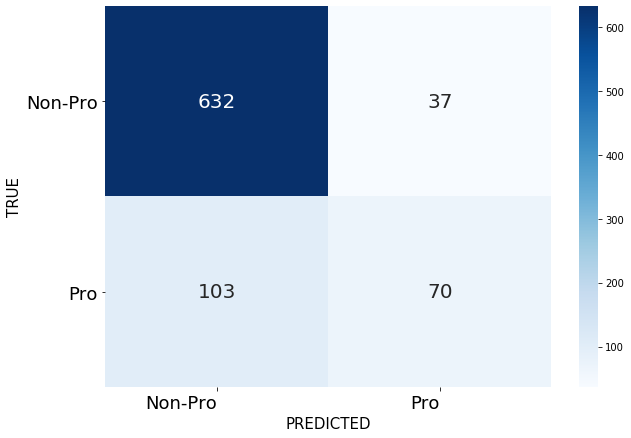

In [10]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_log_reg_base)
cm = print_confusion_matrix(cnf_matrix, ['Non-Pro', 'Pro'], cmap='Blues')

- Not great, but an __improvement over baseline__. 

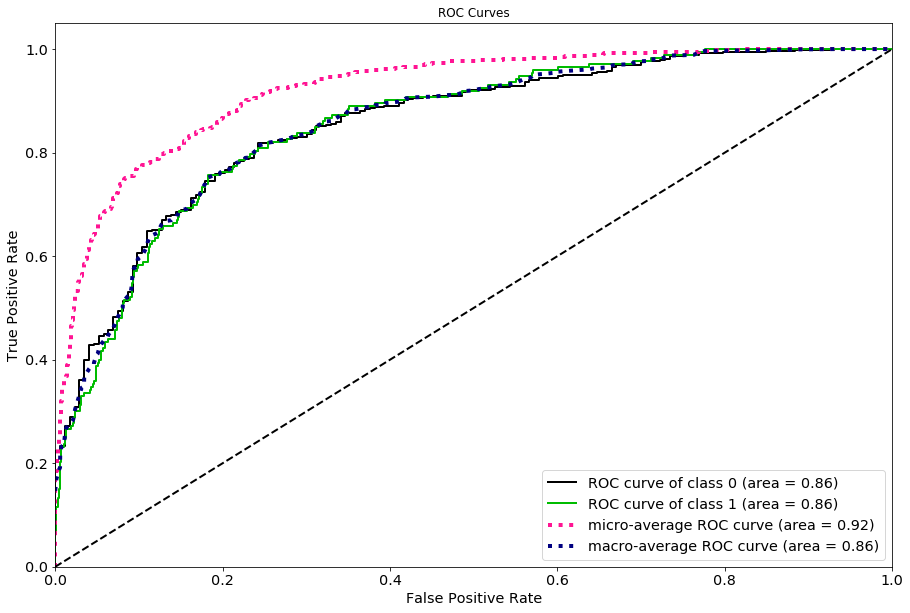

In [11]:
skplt.metrics.plot_roc(y_test, y_probas_log_reg_base, figsize=(15,10), text_fontsize='x-large');

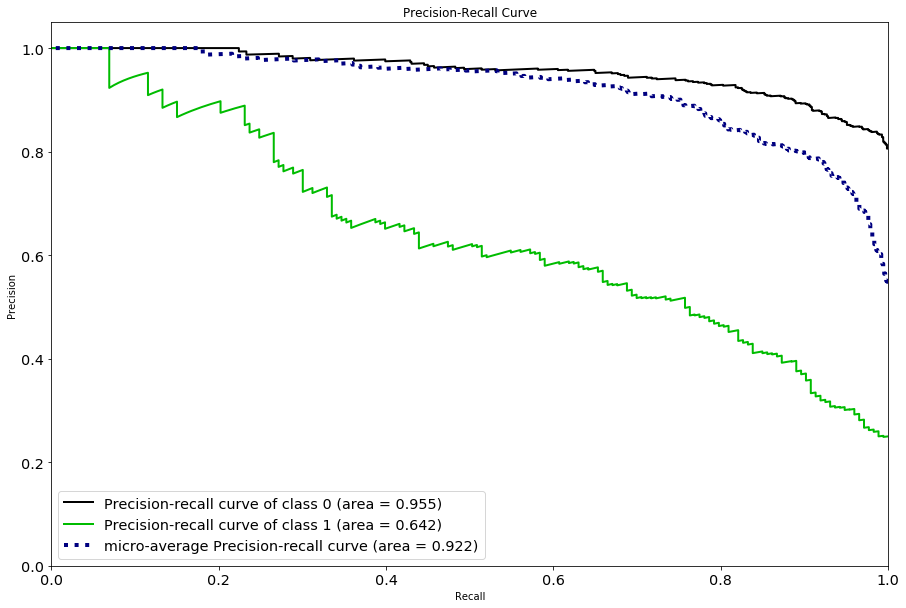

In [12]:
skplt.metrics.plot_precision_recall(y_test, y_probas_log_reg_base, figsize=(15,10), text_fontsize='x-large');

## Logistic Regression - Oversampled
- Now let's try the same test, but with oversampled data, to see if there's a difference. 

In [13]:
log_reg_over = LogisticRegression()
log_reg_over.fit(X_resampled, y_resampled)
y_pred_log_reg_over = log_reg_over.predict(X_test)
y_proba_log_reg_over = log_reg_over.predict_proba(X_test)
score_df(y_test, y_pred_log_reg_over, y_proba_log_reg_over).round(4)

,Scores
f1,0.5887
precision,0.4706
recall,0.7861
accuracy,0.7743
average_precision,0.4139
roc_auc,0.8557


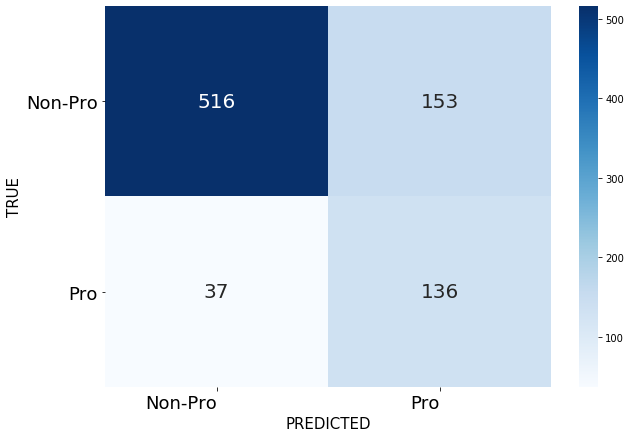

In [14]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_log_reg_over)
cm = print_confusion_matrix(cnf_matrix, ['Non-Pro', 'Pro'], cmap='Blues')

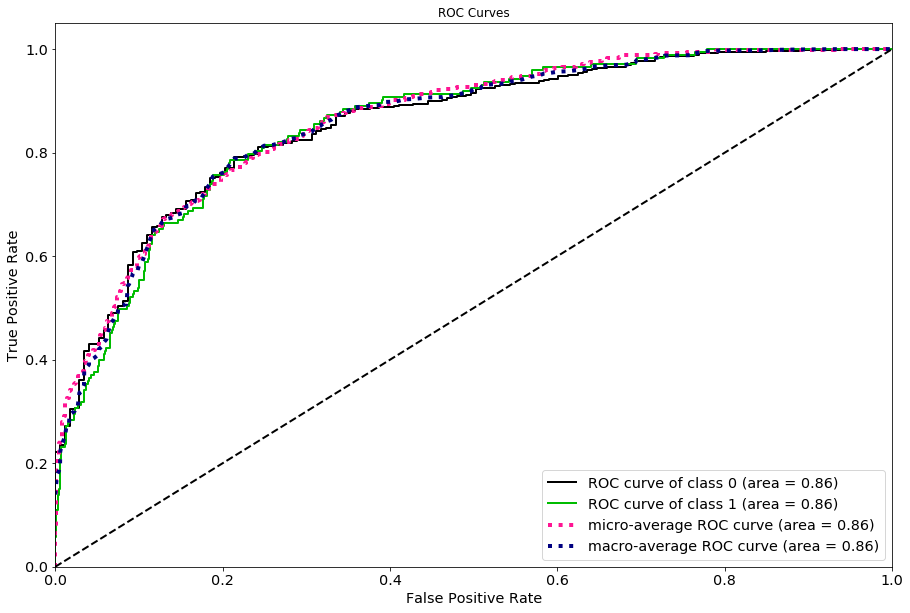

In [15]:
skplt.metrics.plot_roc(y_test, y_proba_log_reg_over, figsize=(15,10), text_fontsize='x-large');

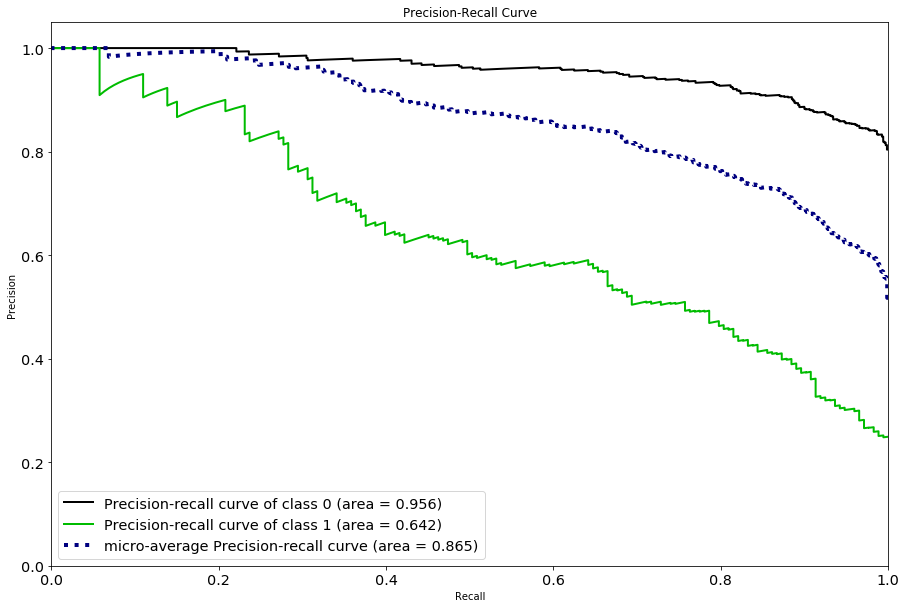

In [16]:
skplt.metrics.plot_precision_recall(y_test, y_proba_log_reg_over, figsize=(15,10), text_fontsize='x-large');

### Logistic Regression - Default Parameters Summary
- Both default parameter logistic models, unsurprisingly, __significantly outperform baseline__, so we know the model is __doing something__. 
- The __oversampled model__ tends to generate __a lot of false positives__, whereas the __non-oversampled model__ generates many __false negatives__. 
- Moving forward I'll __go with the oversampled training data__ as I would like to __err on the side of false positive__ rather than false negative. 

## Logistic Regression - GridSearchCV - L2 Penalty
- Search for optimal parameters using the L2 Ridge regression penalty.

In [17]:
logistic_grid = {'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00005, 0.00001, 0.000001, 1e-07, 1e-08, 1e-09, 1e-10],
                 'penalty': ['l2'],
                 'solver': ['newton-cg', 'lbfgs', 'sag'],
                 'max_iter': [500]}
scores = ['f1', 'precision', 'recall', 'accuracy', 'average_precision', 'roc_auc']

In [18]:
log_reg_clf = LogisticRegression()
log_grid = GridSearchCV(estimator = log_reg_clf, param_grid = logistic_grid, 
                         verbose=2, n_jobs = -1, scoring=scores, refit='f1')
log_grid.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 187 out of 210 | elapsed:    3.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    3.7s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 5e-05,
                               1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10],
                         'max_iter': [500], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'sag']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=Fa

## Results Columns

In [19]:
results_columns = [
 'param_C',
 'param_max_iter',
 'param_penalty',
 'param_solver',
 'mean_test_f1',
 'rank_test_f1',
 'mean_test_precision',
 'rank_test_precision',
 'mean_test_recall',
 'rank_test_recall',
 'mean_test_accuracy',
 'rank_test_accuracy',
 'mean_test_average_precision',
 'rank_test_average_precision',
 'mean_test_roc_auc',
 'rank_test_roc_auc',
 'mean_fit_time',
 'mean_score_time'
]

In [20]:
scores_columns = [ 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_accuracy',
 'mean_test_average_precision',
 'mean_test_roc_auc',
 'mean_fit_time',
 'mean_score_time']

## Logistic Regression (L2) - GridSearchCV Results

In [21]:
log_grid_df = pd.DataFrame(log_grid.cv_results_, columns=results_columns)

In [22]:
log_grid_scores = pd.DataFrame(log_grid_df.sort_values('rank_test_f1'),
                              columns=scores_columns).round(4)

In [23]:
log_grid_scores.iloc[0]

mean_test_f1                   0.7875
mean_test_precision            0.7783
mean_test_recall               0.7978
mean_test_accuracy             0.7845
mean_test_average_precision    0.8549
mean_test_roc_auc              0.8631
mean_fit_time                  0.0472
mean_score_time                0.0127
Name: 15, dtype: float64

In [24]:
log_grid_df.sort_values('rank_test_f1').iloc[0]

param_C                            0.001
param_max_iter                       500
param_penalty                         l2
param_solver                   newton-cg
mean_test_f1                    0.787461
rank_test_f1                           1
mean_test_precision             0.778288
rank_test_precision                   17
mean_test_recall                0.797816
rank_test_recall                       5
mean_test_accuracy              0.784535
rank_test_accuracy                     1
mean_test_average_precision      0.85489
rank_test_average_precision           11
mean_test_roc_auc               0.863102
rank_test_roc_auc                      1
mean_fit_time                  0.0471813
mean_score_time                0.0127214
Name: 15, dtype: object

- Significant improvement over baseline and test scores, though this is training and even though we are regularizing, overfitting can definitely happen. 
- Let's see if different regularization strategies work. 

## Logistic Regression - GridSearchCV - L1 Penalty
- Search for optimal parameters using the L1 LASSO regression penalty.

In [25]:
logistic_grid = {'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00005, 0.00001, 0.000001, 1e-07, 1e-08, 1e-09, 1e-10],
                 'penalty': ['l1'],
                 'solver': ['liblinear', 'saga'],
                 'max_iter': [500]}
scores = ['f1', 'precision', 'recall', 'accuracy', 'average_precision', 'roc_auc']

In [26]:
log_reg_clf_l1 = LogisticRegression()
log_grid_l1 = GridSearchCV(estimator = log_reg_clf_l1, param_grid = logistic_grid, 
                         verbose=2, n_jobs = -1, scoring=scores, refit='f1')
log_grid_l1.fit(X_resampled, y_resampled)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 117 out of 140 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.2s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 5e-05,
                               1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10],
                         'max_iter': [500], 'penalty': ['l1'],
                         'solver': ['liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
   

## Logistic Regression (L1) - GridSearchCV Results

In [27]:
log_grid_l1_df = pd.DataFrame(log_grid_l1.cv_results_, columns=results_columns)

In [28]:
log_grid_l1_scores = pd.DataFrame(log_grid_l1_df.sort_values('rank_test_f1'),
                              columns=scores_columns).round(4)

In [29]:
log_grid_l1_scores.iloc[0]

mean_test_f1                   0.7941
mean_test_precision            0.7604
mean_test_recall               0.8319
mean_test_accuracy             0.7843
mean_test_average_precision    0.8508
mean_test_roc_auc              0.8612
mean_fit_time                  0.0101
mean_score_time                0.0127
Name: 12, dtype: float64

In [30]:
log_grid_l1_df.sort_values('rank_test_f1').iloc[0]

param_C                           0.0001
param_max_iter                       500
param_penalty                         l1
param_solver                   liblinear
mean_test_f1                    0.794128
rank_test_f1                           1
mean_test_precision             0.760401
rank_test_precision                   14
mean_test_recall                0.831851
rank_test_recall                       3
mean_test_accuracy              0.784285
rank_test_accuracy                     2
mean_test_average_precision     0.850793
rank_test_average_precision           13
mean_test_roc_auc               0.861171
rank_test_roc_auc                     13
mean_fit_time                  0.0100566
mean_score_time                0.0127306
Name: 12, dtype: object

- __Not a significant difference between L1 and L2 penalties__.
- As such __we'll go with the default L2 penalty__, which assumes that __we want to keep features__, but __penalize high coefficients__. 

# TEST: Logistic Regression

In [31]:
log_best=LogisticRegression(C=0.001, penalty='l2', solver='newton-cg',max_iter=500)
log_best.fit(X_resampled, y_resampled)
y_pred_best=log_best.predict(X_test)
y_probas_best=log_best.predict_proba(X_test)

In [32]:
score_df(y_test, y_pred_best, y_probas_best).round(4)

,Scores
f1,0.5913
precision,0.4739
recall,0.7861
accuracy,0.7767
average_precision,0.4165
roc_auc,0.8558


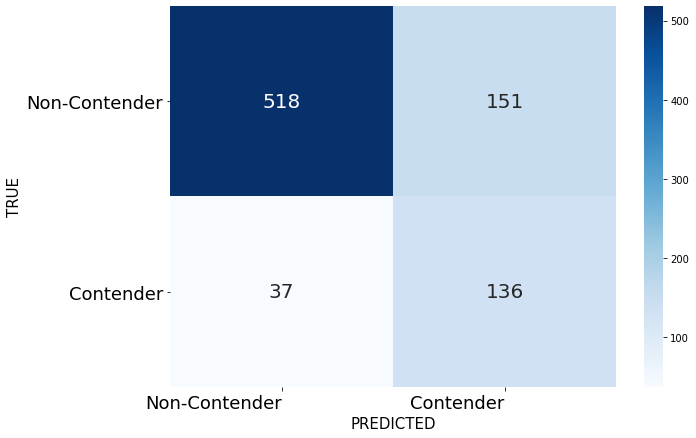

In [33]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred_best)
cm = print_confusion_matrix(cnf_matrix, ['Non-Contender', 'Contender'], cmap='Blues')

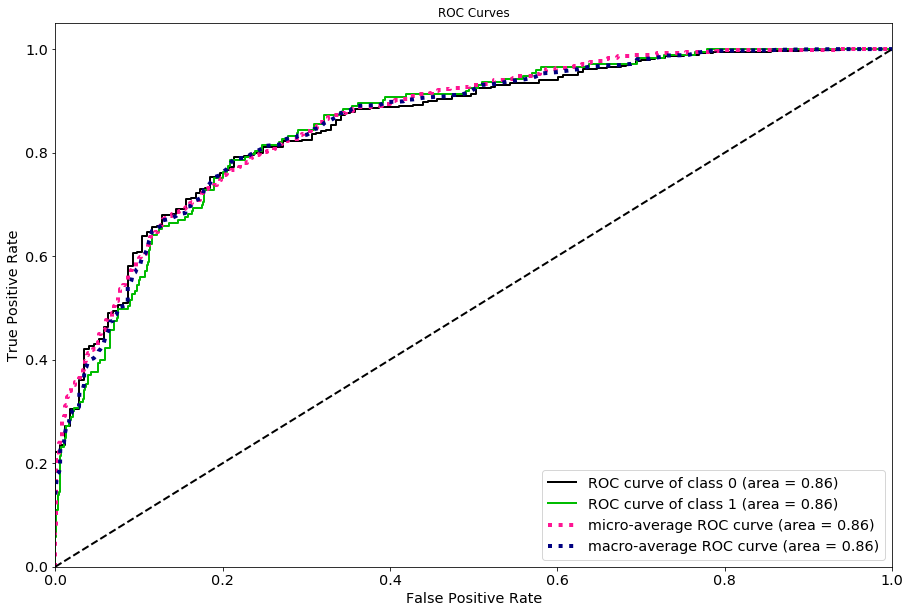

In [34]:
skplt.metrics.plot_roc(y_test, y_probas_best, figsize=(15,10), text_fontsize='x-large');

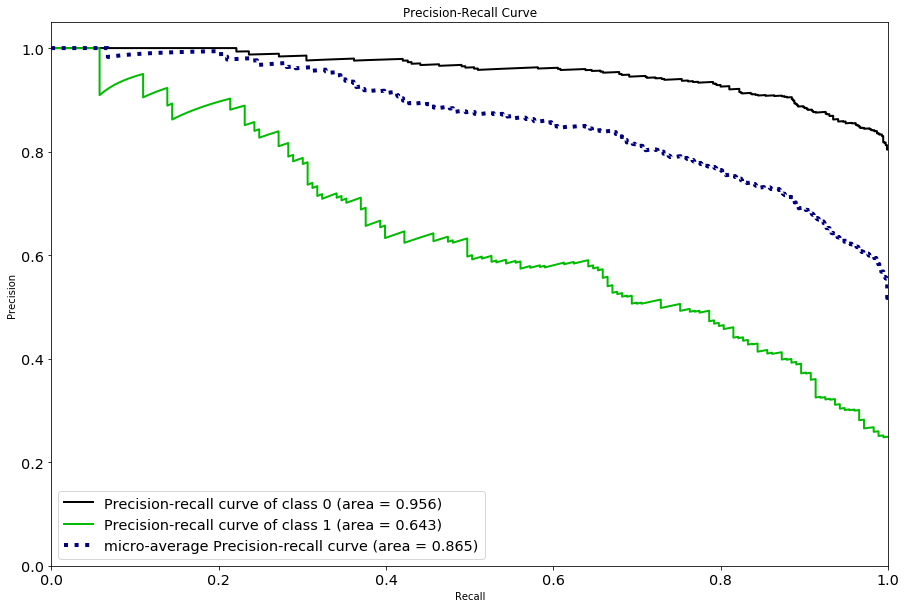

In [35]:
skplt.metrics.plot_precision_recall(y_test, y_probas_best, figsize=(15,10), text_fontsize='x-large');

## Logistic Regression Test Summary
- __Test Results__
 - __F1: 0.5913__
 - __Precision: 0.4739__
 - __Recall: 0.7861__
 - __Accuracy: 0.7767__
 - __Average Precision: 0.4165__
- Very __similar performance to KNN__ in terms of it __prioritizing recall over precision__.
- It's possible to __adjust the precision and recall balance by using different thresholds__ and that's a route we could take if that was a priority. Doing this on test is not revealing though. A threshold should be chosen in the training and validation phase and committed to on test. Changing it after test pollutes the test resluts and degrades generalizablity. 